In [1]:
import fasttext

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import nltk
from nltk.corpus import stopwords

from bs4 import BeautifulSoup

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding,concatenate, Dropout
from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [8]:
data_train = pd.read_csv(r"C:\Users\abhay\IMDB Dataset.csv", nrows = 5000)
data_train.review[1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [9]:
data_train

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
4995,An interesting slasher film with multiple susp...,negative
4996,i watched this series when it first came out i...,positive
4997,Once again Jet Li brings his charismatic prese...,positive
4998,"I rented this movie, after hearing Chris Gore ...",negative


In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5000 non-null   object
 1   sentiment  5000 non-null   object
dtypes: object(2)
memory usage: 78.3+ KB


In [11]:
data_train['review'] = data_train['review'].str.lower()

In [12]:
stop = stopwords.words('english')
data_train['review'] = data_train['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [13]:
data_train['review'][0]

"one reviewers mentioned watching 1 oz episode hooked. right, exactly happened me.<br /><br />the first thing struck oz brutality unflinching scenes violence, set right word go. trust me, show faint hearted timid. show pulls punches regards drugs, sex violence. hardcore, classic use word.<br /><br />it called oz nickname given oswald maximum security state penitentary. focuses mainly emerald city, experimental section prison cells glass fronts face inwards, privacy high agenda. em city home many..aryans, muslims, gangstas, latinos, christians, italians, irish more....so scuffles, death stares, dodgy dealings shady agreements never far away.<br /><br />i would say main appeal show due fact goes shows dare. forget pretty pictures painted mainstream audiences, forget charm, forget romance...oz mess around. first episode ever saw struck nasty surreal, say ready it, watched more, developed taste oz, got accustomed high levels graphic violence. violence, injustice (crooked guards who'll sold

In [14]:
data_train['review'] = data_train['review'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [15]:
data_train['review'][0]

'one reviewers mentioned watching 1 oz episode hooked right exactly happened mebr br the first thing struck oz brutality unflinching scenes violence set right word go trust me show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordbr br it called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awaybr br i would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal say ready it watched more developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away it well mannered midd

In [16]:
# Splitting sentences to words
def splitting(text):
    text = re.split('\W+', text)
    return text

data_train['review'] = data_train['review'].apply(lambda x: splitting(x.lower()))
data_train.head()

,review,sentiment
0,"[one, reviewers, mentioned, watching, 1, oz, e...",positive
1,"[wonderful, little, production, br, br, the, f...",positive
2,"[thought, wonderful, way, spend, time, hot, su...",positive
3,"[basically, theres, family, little, boy, jake,...",negative
4,"[petter, matteis, love, time, money, visually,...",positive


In [17]:
# Lemmitization
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

data_train['review'] = data_train['review'].apply(lambda x: lemmatizer(x))
data_train.head()

,review,sentiment
0,"[one, reviewer, mentioned, watching, 1, oz, ep...",positive
1,"[wonderful, little, production, br, br, the, f...",positive
2,"[thought, wonderful, way, spend, time, hot, su...",positive
3,"[basically, there, family, little, boy, jake, ...",negative
4,"[petter, matteis, love, time, money, visually,...",positive


In [18]:
# Stemming
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

data_train['review'] = data_train['review'].apply(lambda x: stemming(x))
data_train.head()

,review,sentiment
0,"[one, review, mention, watch, 1, oz, episod, h...",positive
1,"[wonder, littl, product, br, br, the, film, te...",positive
2,"[thought, wonder, way, spend, time, hot, summe...",positive
3,"[basic, there, famili, littl, boy, jake, think...",negative
4,"[petter, mattei, love, time, money, visual, st...",positive


In [83]:
# model = fasttext.train_unsupervised(r"C:\Users\abhay\data_train.txt")
# model.save_model('fasttext_embedding_model')

In [85]:
model = fasttext.load_model('fasttext_embedding_model.bin')

In [86]:
model.get_nearest_neighbors('0')

[(0.8030160665512085, '10'),
 (0.7545254826545715, 'rating'),
 (0.7452172040939331, '5'),
 (0.7371419668197632, '4'),
 (0.7264859676361084, '1'),
 (0.7015824913978577, "'1'"),
 (0.6827268600463867, "'10"),
 (0.6719403862953186, '7'),
 (0.671427845954895, '8'),
 (0.6650434136390686, '9')]

In [87]:
model.get_word_vector('br')

array([ 3.57556641e-01,  1.57288939e-01,  4.22017649e-02, -8.30134973e-02,
       -3.33866328e-02, -2.21145973e-01,  7.82471597e-02, -4.17709053e-02,
        9.52527598e-02, -3.34669687e-02, -3.90891910e-01,  2.71300413e-02,
       -2.18692914e-01, -2.49209702e-02,  1.78961456e-03,  1.50217772e-01,
       -7.00644553e-02, -1.30738899e-01, -2.18264330e-02, -7.57301599e-02,
       -1.90378100e-01,  2.02515900e-01, -6.36990890e-02,  8.87535661e-02,
       -3.12903076e-02, -2.15741977e-01, -1.90676376e-02,  1.28298089e-01,
        1.26422793e-01,  7.30755180e-03, -3.83870304e-02,  7.56041408e-02,
        3.05536538e-01,  1.97547555e-01,  6.71051443e-03, -3.47235054e-03,
       -2.86998302e-01,  1.43532783e-01,  1.42809853e-01,  1.48083180e-01,
        3.14759374e-01, -1.74648724e-02, -6.22058362e-02,  2.09614366e-01,
       -1.53232485e-01,  2.51472682e-01,  4.21421617e-01, -4.22203764e-02,
        3.07794604e-02, -4.61425558e-02, -2.54705548e-04, -1.09250434e-01,
        3.31278741e-02,  

In [88]:
p = model.get_input_matrix()
p[0]

array([ 1.02421304e-03, -2.62799710e-01, -3.86847258e-01, -5.21471016e-02,
       -4.79752850e-03,  1.11266041e+00,  6.84959650e-01, -2.27930024e-02,
       -6.00151159e-02,  2.56530851e-01, -2.08361670e-01,  2.84435332e-01,
        4.51051414e-01, -4.11420316e-01,  2.32437313e-01, -2.63810456e-01,
       -1.08557391e+00, -4.84807462e-01,  2.44566381e-01, -1.79374054e-01,
        3.53058726e-01, -1.51229501e-01,  8.79598498e-01, -5.36291003e-01,
       -5.30020833e-01,  1.26384646e-01, -3.74596305e-02,  5.46082914e-01,
       -5.67966163e-01, -4.94859576e-01, -9.52866897e-02,  1.62283450e-01,
       -1.91900283e-01, -1.50684446e-01,  7.31156051e-01,  6.47139847e-02,
        4.34587419e-01, -5.68434894e-01,  4.29004163e-01, -7.65340269e-01,
       -2.35657722e-01,  4.20346737e-01,  4.48330380e-02, -3.21218461e-01,
        1.47922724e-01, -4.09175843e-01, -3.25412363e-01, -1.34833798e-01,
       -8.18336532e-02,  3.49519141e-02,  3.86114836e-01, -3.75171065e-01,
        4.14607614e-01, -

In [89]:
# dir(model)

In [90]:
# Tokenization
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data_train['review'])
sequences = tokenizer.texts_to_sequences(data_train['review'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 37585 unique tokens.


In [92]:
# data_train.review[0]

In [93]:
# Label encoding of data_train['sentiment']
data_train['sentiment'] = data_train['sentiment'].replace('negative',0)
data_train['sentiment'] = data_train['sentiment'].replace('positive',1)
labels = data_train['sentiment']
labels

0       1
1       1
2       1
3       0
4       1
       ..
4995    0
4996    1
4997    1
4998    0
4999    0
Name: sentiment, Length: 5000, dtype: int64

In [94]:
# data = data_train.review.copy()
# for i in range(data.shape[0]):
    

In [95]:
a

[1, 2, 3, 4, 5, 6]

In [96]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (5000, 1000)
Shape of label tensor: (5000, 2)


In [97]:
EMBEDDING_DIM

100

In [98]:
# !pip install fasttext
import fasttext

In [99]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = model.get_word_vector(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [100]:
embedding_matrix[1]

array([ 3.57556641e-01,  1.57288939e-01,  4.22017649e-02, -8.30134973e-02,
       -3.33866328e-02, -2.21145973e-01,  7.82471597e-02, -4.17709053e-02,
        9.52527598e-02, -3.34669687e-02, -3.90891910e-01,  2.71300413e-02,
       -2.18692914e-01, -2.49209702e-02,  1.78961456e-03,  1.50217772e-01,
       -7.00644553e-02, -1.30738899e-01, -2.18264330e-02, -7.57301599e-02,
       -1.90378100e-01,  2.02515900e-01, -6.36990890e-02,  8.87535661e-02,
       -3.12903076e-02, -2.15741977e-01, -1.90676376e-02,  1.28298089e-01,
        1.26422793e-01,  7.30755180e-03, -3.83870304e-02,  7.56041408e-02,
        3.05536538e-01,  1.97547555e-01,  6.71051443e-03, -3.47235054e-03,
       -2.86998302e-01,  1.43532783e-01,  1.42809853e-01,  1.48083180e-01,
        3.14759374e-01, -1.74648724e-02, -6.22058362e-02,  2.09614366e-01,
       -1.53232485e-01,  2.51472682e-01,  4.21421617e-01, -4.22203764e-02,
        3.07794604e-02, -4.61425558e-02, -2.54705548e-04, -1.09250434e-01,
        3.31278741e-02,  

In [101]:
model.get_word_vector('br')

array([ 3.57556641e-01,  1.57288939e-01,  4.22017649e-02, -8.30134973e-02,
       -3.33866328e-02, -2.21145973e-01,  7.82471597e-02, -4.17709053e-02,
        9.52527598e-02, -3.34669687e-02, -3.90891910e-01,  2.71300413e-02,
       -2.18692914e-01, -2.49209702e-02,  1.78961456e-03,  1.50217772e-01,
       -7.00644553e-02, -1.30738899e-01, -2.18264330e-02, -7.57301599e-02,
       -1.90378100e-01,  2.02515900e-01, -6.36990890e-02,  8.87535661e-02,
       -3.12903076e-02, -2.15741977e-01, -1.90676376e-02,  1.28298089e-01,
        1.26422793e-01,  7.30755180e-03, -3.83870304e-02,  7.56041408e-02,
        3.05536538e-01,  1.97547555e-01,  6.71051443e-03, -3.47235054e-03,
       -2.86998302e-01,  1.43532783e-01,  1.42809853e-01,  1.48083180e-01,
        3.14759374e-01, -1.74648724e-02, -6.22058362e-02,  2.09614366e-01,
       -1.53232485e-01,  2.51472682e-01,  4.21421617e-01, -4.22203764e-02,
        3.07794604e-02, -4.61425558e-02, -2.54705548e-04, -1.09250434e-01,
        3.31278741e-02,  

In [102]:
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

In [103]:
# Train test validation Split
from sklearn.model_selection import train_test_split

# indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( data, labels, test_size=0.50, random_state=32)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test),y_train.shape)

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 4000 2500 2500 (4000, 2)
real & fake news in train,valt,test:
[2002. 1998.]
[1270. 1230.]
[1262. 1238.]


In [104]:
x_train.shape

(4000, 1000)

In [105]:
EMBEDDING_DIM

100

In [106]:
MAX_SEQUENCE_LENGTH

1000

In [107]:
# embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)

In [108]:
# Simple CNN model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(256, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(256, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(256, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(256, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['acc'])

print("Fitting the simple convolutional neural network model")
model.summary()


Fitting the simple convolutional neural network model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 100)         3758600   
                                                                 
 conv1d (Conv1D)             (None, 996, 256)          128256    
                                                                 
 max_pooling1d (MaxPooling1  (None, 199, 256)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 195, 256)          327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 39, 256)           0         
 g1D)  

In [109]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128, verbose=1)

Epoch 1/10
32/32 [==============================] - 46s 1s/step - loss: 0.6955 - acc: 0.5595 - val_loss: 0.6014 - val_acc: 0.7000
Epoch 2/10
32/32 [==============================] - 43s 1s/step - loss: 0.5085 - acc: 0.7667 - val_loss: 0.3131 - val_acc: 0.8748
Epoch 3/10
32/32 [==============================] - 42s 1s/step - loss: 0.2740 - acc: 0.8907 - val_loss: 0.2241 - val_acc: 0.9208
Epoch 4/10
32/32 [==============================] - 43s 1s/step - loss: 0.1385 - acc: 0.9480 - val_loss: 0.1321 - val_acc: 0.9552
Epoch 5/10
32/32 [==============================] - 43s 1s/step - loss: 0.0485 - acc: 0.9860 - val_loss: 0.7466 - val_acc: 0.7796
Epoch 6/10
32/32 [==============================] - 43s 1s/step - loss: 0.1957 - acc: 0.9625 - val_loss: 0.1341 - val_acc: 0.9652
Epoch 7/10
32/32 [==============================] - 42s 1s/step - loss: 0.0108 - acc: 0.9970 - val_loss: 0.1698 - val_acc: 0.9688
Epoch 8/10
32/32 [==============================] - 43s 1s/step - loss: 0.0021 - acc: 0.99

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


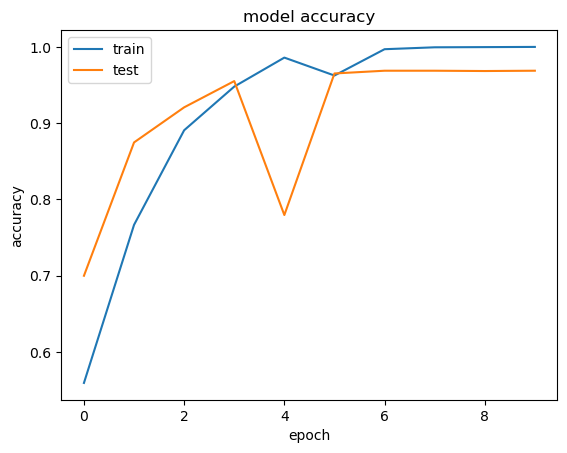

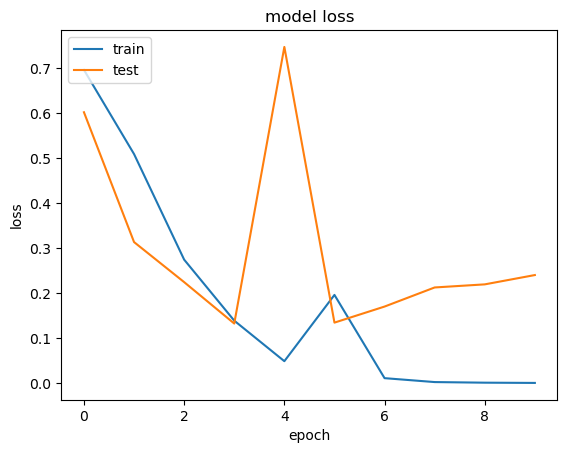

In [110]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [111]:
from keras.layers import Concatenate

In [112]:
x_train.shape

(4000, 1000)

In [114]:



convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(128,fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)   
l_merge = Concatenate()(convs)
l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
#l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(convs)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model2 = Model(sequence_input, preds)
model2.compile(loss='categorical_crossentropy',
              optimizer='Nadam',
              metrics=['acc'])

print("Fitting a more complex convolutional neural network model")
model2.summary()
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=128, verbose=1)
# model2.save('model.h5')

Fitting a more complex convolutional neural network model
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1000, 100)            3758600   ['input_3[0][0]']             
                                                                                                  
 conv1d_8 (Conv1D)           (None, 998, 128)             38528     ['embedding[1][0]']           
                                                                                                  
 conv1d_9 (Conv1D)           (None, 997, 128)             51328     ['embedding[1][0]']           
                                  

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


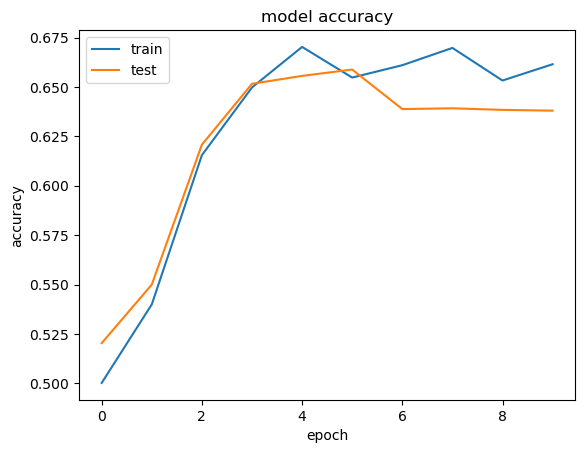

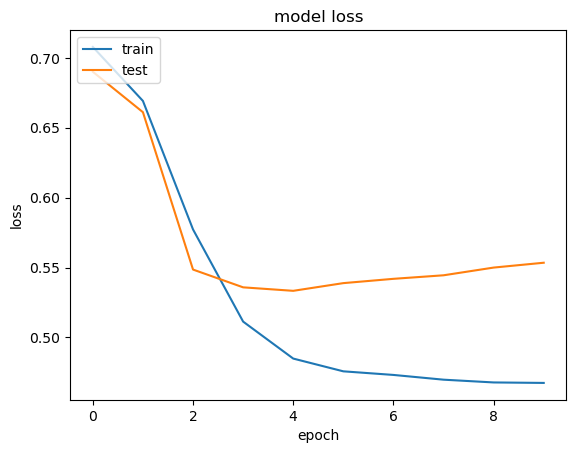

In [115]:
# list all data in history
print(history2.history.keys())
import matplotlib.pyplot as plt
%matplotlib inline 
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

79/79 [==============================] - 5s 63ms/step
Correct predictions: 2427.0
Total number of test examples: 2500
Accuracy of model1:  0.9708
79/79 [==============================] - 5s 67ms/step
Correct predictions: 1620.0
Total number of test examples: 2500
Accuracy of model2:  0.648
79/79 [==============================] - 5s 66ms/step


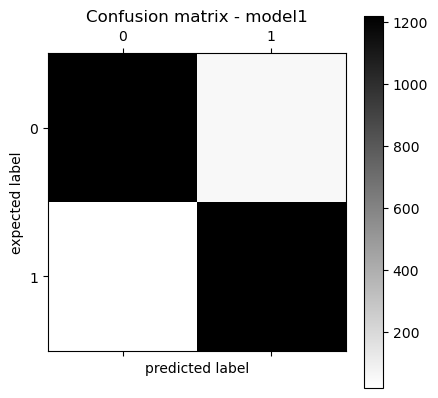

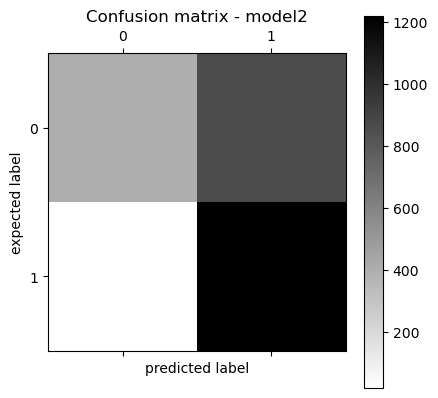

In [116]:
# Test model 1
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = model.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - model1')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
# plt.show()

#Test model 2
test_preds2 = model2.predict(x_test)
test_preds2 = np.round(test_preds2)
correct_predictions = float(sum(test_preds2 == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model2: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
x_pred = model2.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest',)
plt.title('Confusion matrix - model2')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

In [117]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.17564748227596283
Test accuracy: 0.97079998254776


In [118]:
score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5825088024139404
Test accuracy: 0.6480000019073486
